In [1]:
!nvidia-smi

Thu May 26 20:51:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import glob

import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

import torch 
from torch import nn 
import torch.nn.functional as F 
from torch import optim 
import torchvision 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Move data from drive to colab instance

In [4]:
from distutils.file_util import copy_file
copy_file("/content/drive/Shareddrives/Pattern/river_data2.zip", "/content")

('/content/river_data2.zip', 1)

In [5]:
# create river dir
!mkdir river_samples

In [6]:
# unzip file
import shutil
shutil.unpack_archive('/content/river_data2.zip', '')

In [7]:
# move file
import shutil
shutil.move('/content/content/river_samples/content/training_samples', '/content')

'/content/training_samples'

In [8]:
# count file
import os

path, dirs, files = next(os.walk("/content/training_samples/river/bucketed"))
file_count = len(files)
print(file_count/2)

116682.0


In [9]:
root = '/content/training_samples/river/bucketed'

# Dataset / DataLoader

In [10]:
# Config batch size

train_batch_size = 1000
val_batch_size = 1000
test_batch_size = 1000

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# Dataset for CFV data 

class CFVDataset(Dataset):
    def __init__(self, x, y, preprocess=None):
        self.x = x
        self.y = y
        # self.x = glob.glob(os.path.join(root, '*.inputs'))
        # self.y = glob.glob(os.path.join(root, '*.targets'))
        self.preprocess = preprocess

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x_data = torch.load(self.x[idx],map_location=torch.device(device))
        y_data = torch.load(self.y[idx],map_location=torch.device(device))
        mask =  torch.clone(y_data)
        mask[mask != 0] = 1

        return x_data, y_data, mask

In [13]:
data_x = sorted(glob.glob(os.path.join(root, '*.inputs')))
data_y = sorted(glob.glob(os.path.join(root, '*.targets')))

In [14]:
data_x_train = data_x[:int(len(data_x)*0.8)]
data_x_val = data_x[int(len(data_x)*0.8):int(len(data_x)*0.9)]
data_x_test = data_x[int(len(data_x)*0.9):]

In [15]:
data_y_train = data_y[:int(len(data_y)*0.8)]
data_y_val = data_y[int(len(data_y)*0.8):int(len(data_x)*0.9)]
data_y_test = data_y[int(len(data_y)*0.9):]

In [16]:
# Train and Val data loader

train_dataset = CFVDataset(x=data_x_train,y=data_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=False)
val_dataset = CFVDataset(x=data_x_val,y=data_y_val)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, pin_memory=False)
test_dataset = CFVDataset(x=data_x_test,y=data_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, pin_memory=False)

# Loss Function

In [17]:
def smoothL1LossForward(outputs, targets):
    # Smooth L1 Loss for two vectors
    n = torch.abs(outputs - targets)
    beta = 1
    cond = n < beta
    z = torch.where(cond, 0.5 * n ** 2 / beta, n - 0.5 * beta)
    return z.mean()

In [18]:
class MaskedHuberLoss(nn.Module):

    def __init__(self):
        super(MaskedHuberLoss, self).__init__()


    def forward(self, outputs, targets, masks):
        # Reshape tesnsors
        outputs = outputs.squeeze(1)
        targets = targets.squeeze(1)
        masks = masks.squeeze(1)

        batch_size = outputs.size(0)
        feature_size = outputs.size(1)

        # Zero out the outputs/target so that the error does not depend on these
        outputs.mul_(masks)
        targets.mul_(masks)
        
        loss = smoothL1LossForward(outputs, targets)
        
        # If the batch size has changed, create new storage for the sum, otherwise reuse
        mask_placeholder = torch.zeros_like(masks).to(device)
        mask_sum = torch.FloatTensor(batch_size).fill_(0).to(device)
        mask_multiplier = mask_sum.clone().fill_(0).view(-1, 1).to(device)

        # Compute mask sum for each batch
        mask_placeholder.copy_(masks)
        mask_sum = mask_placeholder.sum(dim=1, keepdim=True)
        

        # Mask multiplier - note that mask is 1 for impossible features
        mask_multiplier = mask_multiplier.fill_(feature_size)
        mask_multiplier = mask_multiplier.sub_(mask_sum)
        mask_multiplier = mask_multiplier.div_(feature_size)
        
        # Multiply to get a new losss
        # Loss is not really computed batch-wise correctly,
        # But that does not really matter now since gradients are correct
        loss_multiplier = (batch_size * feature_size) / (batch_size * feature_size - mask_sum.sum() )
        new_loss = loss_multiplier * loss

        return new_loss

In [19]:
loss_function = MaskedHuberLoss()

# Model

In [20]:
# Config input and output size // must match the bucketed size
ip_size = train_dataset[0][0].shape[1]
op_size = train_dataset[0][1].shape[1]

## Baseline Model

In [21]:
# Baseline model from the paper

class BaselineNN(nn.Module):
    def __init__(self, hidden_size=500,input_size=ip_size,output_size=op_size):
        super(BaselineNN, self).__init__()
        
        model = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.PReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.PReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.PReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.PReLU(),
          nn.Linear(hidden_size, output_size),
        )

        self.model = model
        self.input_size = input_size
        self.output_size = output_size

    def forward(self, x):
        # Normal ff
        feedforward = self.model(x)

        # Zerosum part
        ranges = torch.narrow(x,2, 0, self.output_size)
        batch1 = feedforward
        batch2 = torch.moveaxis(ranges,1,2)
        estimated_value = torch.bmm(batch1, batch2).squeeze(2)        
        estimated_value = estimated_value.repeat(1, self.output_size).unsqueeze(1)
        estimated_value = torch.mul(estimated_value, -0.5)
        final_mlp = torch.add(feedforward, estimated_value)

        return final_mlp

# Initialize the Model

In [23]:
# Init baseline model

baseline_model = BaselineNN()
baseline_model.to(device)
print(baseline_model)

BaselineNN(
  (model): Sequential(
    (0): Linear(in_features=1009, out_features=500, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): PReLU(num_parameters=1)
    (8): Linear(in_features=500, out_features=1008, bias=True)
  )
)


# Optimizer

In [ ]:
# Hyperparameters and other configs

config = {
    'architecture': 'feedforward',
    'lr': 0.001,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 50
}

In [ ]:
# Use Adam as optmizer

optimizer = torch.optim.Adam(baseline_model.parameters(), lr=config['lr'])

# Just simply scheduler

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config['scheduler_factor'], 
    patience=config['scheduler_patience'], 
    min_lr=config['scheduler_min_lr']
)

# Training and Results

## Baseline Model

### Training

In [ ]:
# Start training baseline model

model_name = 'baseline_model'

train_losses = []
val_losses = []

for epoch in range(config['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']

    # Flag model as training. 
    baseline_model.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, targets, masks) in enumerate(tqdm(train_dataloader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = baseline_model(inputs)

        # Calculate loss
        loss = loss_function(y_pred, targets, masks)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    baseline_model.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true, masks) in enumerate(tqdm(val_dataloader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Predict
            y_pred = baseline_model(inputs)

            # Calculate loss
            loss = loss_function(y_pred, y_true, masks)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': baseline_model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, f'/content/drive/Shareddrives/Pattern/model/{model_name}_{calendar.timegm(datetime.utcnow().utctimetuple())}.pth.tar')

print('Finished Training')

Training epoch 1...
Current LR: 0.001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 1 train loss: 0.0324
Validating epoch 1


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 1 val loss: 0.0316
Saving new best model..
Training epoch 2...
Current LR: 0.001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 2 train loss: 0.0313
Validating epoch 2


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 2 val loss: 0.0311
Saving new best model..
Training epoch 3...
Current LR: 0.001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 3 train loss: 0.0309
Validating epoch 3


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 3 val loss: 0.0309
Saving new best model..
Training epoch 4...
Current LR: 0.001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 4 train loss: 0.0305
Validating epoch 4


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 4 val loss: 0.0309
Saving new best model..
Training epoch 5...
Current LR: 0.001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 5 train loss: 0.0302
Validating epoch 5


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 5 val loss: 0.0311
Training epoch 6...
Current LR: 0.001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 6 train loss: 0.0295
Validating epoch 6


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 6 val loss: 0.0314
Training epoch 7...
Current LR: 0.001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 7 train loss: 0.0286
Validating epoch 7


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 7 val loss: 0.0320
Training epoch 8...
Current LR: 0.0002


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 8 train loss: 0.0261
Validating epoch 8


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 8 val loss: 0.0331
Training epoch 9...
Current LR: 0.0002


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 9 train loss: 0.0250
Validating epoch 9


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 9 val loss: 0.0336
Training epoch 10...
Current LR: 0.0002


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 10 train loss: 0.0241
Validating epoch 10


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 10 val loss: 0.0343
Training epoch 11...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 11 train loss: 0.0232
Validating epoch 11


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 11 val loss: 0.0347
Training epoch 12...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 12 train loss: 0.0228
Validating epoch 12


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 12 val loss: 0.0351
Training epoch 13...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 13 train loss: 0.0224
Validating epoch 13


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 13 val loss: 0.0352
Training epoch 14...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 14 train loss: 0.0220
Validating epoch 14


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 14 val loss: 0.0356
Training epoch 15...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 15 train loss: 0.0217
Validating epoch 15


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 15 val loss: 0.0359
Training epoch 16...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 16 train loss: 0.0214
Validating epoch 16


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 16 val loss: 0.0363
Training epoch 17...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 17 train loss: 0.0210
Validating epoch 17


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 17 val loss: 0.0365
Training epoch 18...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 18 train loss: 0.0207
Validating epoch 18


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 18 val loss: 0.0366
Training epoch 19...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 19 train loss: 0.0204
Validating epoch 19


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 19 val loss: 0.0369
Training epoch 20...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 20 train loss: 0.0201
Validating epoch 20


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 20 val loss: 0.0372
Training epoch 21...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 21 train loss: 0.0198
Validating epoch 21


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 21 val loss: 0.0376
Training epoch 22...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 22 train loss: 0.0196
Validating epoch 22


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 22 val loss: 0.0379
Training epoch 23...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 23 train loss: 0.0193
Validating epoch 23


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 23 val loss: 0.0381
Training epoch 24...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 24 train loss: 0.0190
Validating epoch 24


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 24 val loss: 0.0382
Training epoch 25...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 25 train loss: 0.0188
Validating epoch 25


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 25 val loss: 0.0385
Training epoch 26...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 26 train loss: 0.0185
Validating epoch 26


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 26 val loss: 0.0386
Training epoch 27...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 27 train loss: 0.0183
Validating epoch 27


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 27 val loss: 0.0389
Training epoch 28...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 28 train loss: 0.0181
Validating epoch 28


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 28 val loss: 0.0391
Training epoch 29...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 29 train loss: 0.0179
Validating epoch 29


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 29 val loss: 0.0393
Training epoch 30...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 30 train loss: 0.0177
Validating epoch 30


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 30 val loss: 0.0396
Training epoch 31...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 31 train loss: 0.0175
Validating epoch 31


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 31 val loss: 0.0398
Training epoch 32...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 32 train loss: 0.0173
Validating epoch 32


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 32 val loss: 0.0400
Training epoch 33...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 33 train loss: 0.0171
Validating epoch 33


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 33 val loss: 0.0402
Training epoch 34...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 34 train loss: 0.0169
Validating epoch 34


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 34 val loss: 0.0406
Training epoch 35...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 35 train loss: 0.0167
Validating epoch 35


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 35 val loss: 0.0409
Training epoch 36...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 36 train loss: 0.0165
Validating epoch 36


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 36 val loss: 0.0411
Training epoch 37...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 37 train loss: 0.0164
Validating epoch 37


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 37 val loss: 0.0413
Training epoch 38...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 38 train loss: 0.0162
Validating epoch 38


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 38 val loss: 0.0414
Training epoch 39...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 39 train loss: 0.0160
Validating epoch 39


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 39 val loss: 0.0417
Training epoch 40...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 40 train loss: 0.0159
Validating epoch 40


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 40 val loss: 0.0418
Training epoch 41...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 41 train loss: 0.0157
Validating epoch 41


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 41 val loss: 0.0419
Training epoch 42...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 42 train loss: 0.0156
Validating epoch 42


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 42 val loss: 0.0424
Training epoch 43...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 43 train loss: 0.0154
Validating epoch 43


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 43 val loss: 0.0425
Training epoch 44...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 44 train loss: 0.0153
Validating epoch 44


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 44 val loss: 0.0429
Training epoch 45...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 45 train loss: 0.0151
Validating epoch 45


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 45 val loss: 0.0429
Training epoch 46...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 46 train loss: 0.0150
Validating epoch 46


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 46 val loss: 0.0431
Training epoch 47...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 47 train loss: 0.0149
Validating epoch 47


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 47 val loss: 0.0434
Training epoch 48...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 48 train loss: 0.0147
Validating epoch 48


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 48 val loss: 0.0435
Training epoch 49...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 49 train loss: 0.0146
Validating epoch 49


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 49 val loss: 0.0436
Training epoch 50...
Current LR: 0.0001


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch 50 train loss: 0.0144
Validating epoch 50


  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 50 val loss: 0.0438
Finished Training


### Train and Val loss

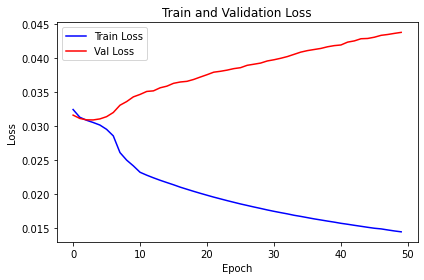

In [ ]:
# Plot trian loss and val loss

plt.plot(train_losses, label='Train Loss', color='b')
plt.plot(val_losses, label='Val Loss', color='r')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Save loss log

import pandas as pd

loss_df = pd.DataFrame({'train' : train_losses,
                        'val' : val_losses})
loss_df.to_csv(f'/content/drive/Shareddrives/Pattern/model/{model_name}_{calendar.timegm(datetime.utcnow().utctimetuple())}.csv')

### Save & Load model

In [ ]:
# from datetime import datetime
# import calendar
# torch.save(baseline_model.state_dict(), f'/content/drive/Shareddrives/Pattern/model/{model_name}_{calendar.timegm(datetime.utcnow().utctimetuple())}.pth.tar')

In [ ]:
# best_model_path = ""

# best_baseline_model = BaselineNN()
# best_baseline_model = torch.load(best_model_path)
# best_baseline_model.eval()

# Misc

In [ ]:
# Test inference
with torch.no_grad():
    baseline_model.eval()
    result = baseline2_model(val_dataset[0][0].unsqueeze(1))

torch.set_printoptions(threshold=10_000)
print(val_dataset[0][1])
print("-------")
print(result[0][0].mul_(val_dataset[0][2].squeeze(0)))